In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Importing data

In [2]:
df = pd.read_csv('./main.csv')
'''
TT_16: temp sensor
PYNM_02: temp sensor
TT_11: temp sensor
FT_02: flow meter sensor
Wind_Velocity: wind velocity sensor
HG_ARRAY_02: output
'''
df['Time'] = pd.to_datetime(df['Time'])
print(df.info(), '\n')
print('Shape:', df.shape)
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 8 columns):
Time             380 non-null datetime64[ns]
Day_Of_Year      380 non-null int64
TT_16            320 non-null float64
PYNM_02          281 non-null float64
TT_11            346 non-null float64
FT_02            317 non-null float64
Wind_Velocity    141 non-null float64
HG_ARRAY_02      317 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 23.8 KB
None 

Shape: (380, 8)


,Day_Of_Year,TT_16,PYNM_02,TT_11,FT_02,Wind_Velocity,HG_ARRAY_02
count,380.000000,320.000000,281.000000,346.000000,317.000000,141.000000,317.000000
mean,186.039474,36.974279,207.002671,44.318522,16.284703,6.334623,2406.423130
std,104.489391,7.447439,109.232638,8.440823,5.683094,6.370754,988.790052
min,1.000000,10.228881,0.369346,13.459877,0.001083,2.846667,0.059000
25%,95.750000,32.612818,121.771422,39.107805,18.545000,3.897917,2051.504053
50%,190.500000,38.562039,192.711513,45.577744,18.808374,4.889875,2702.602761
75%,270.250000,42.333324,300.745522,50.011727,18.875271,6.183125,3142.004482
max,365.000000,59.021930,572.164179,71.519737,19.289717,35.841667,4396.358658


## Plots with raw data

In [ ]:
df.loc[:, 'TT_16':].plot(kind = 'box', subplots = True, figsize = (20, 8))

In [ ]:
sns.set_style("darkgrid")
sns.pairplot(df, hue = None, kind = "scatter")
plt.show()

# Data cleaning

In [3]:
dft = df.copy()
dft.drop(dft[dft.isnull().sum(axis = 1) > 3].index, axis = 0, inplace = True)
dft.drop(dft[dft['HG_ARRAY_02'].isnull()].index, axis = 0, inplace = True)
dft.drop(dft[dft['HG_ARRAY_02'] < 500].index, axis = 0, inplace = True)
dft.drop(dft[dft['Wind_Velocity'] > 10].index, axis = 0, inplace = True)
for index, row in dft[dft['Wind_Velocity'].isnull()].iterrows():
    dft.loc[index, 'Wind_Velocity'] = np.random.normal(dft['Wind_Velocity'].mean(), dft['Wind_Velocity'].std())
for index, row in dft[dft['TT_16'].isnull()].iterrows():
    dft.loc[index, 'TT_16'] = dft.loc[index, 'TT_11'] + np.random.normal((dft['TT_16'] - dft['TT_11']).mean(), (dft['TT_16'] - dft['TT_11']).std())
for index, row in dft[dft['PYNM_02'].isnull()].iterrows():
    dft.loc[index, 'PYNM_02'] = np.random.normal(dft['PYNM_02'].mean(), dft['PYNM_02'].std())
print('Shape:', dft.shape)
dft.describe()

Shape: (282, 8)


,Day_Of_Year,TT_16,PYNM_02,TT_11,FT_02,Wind_Velocity,HG_ARRAY_02
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,187.464539,39.064041,230.114467,46.405534,17.799943,4.912422,2649.707232
std,100.471985,5.766133,99.854351,6.360702,3.054984,1.223778,680.453999
min,18.000000,18.861726,4.465026,22.902206,0.067164,1.406304,621.765999
25%,97.250000,34.653493,156.205326,41.901825,18.680749,4.015822,2314.020512
50%,179.500000,39.816585,216.148176,47.281623,18.819865,4.857113,2805.310086
75%,269.750000,43.174861,315.349594,50.781771,18.877900,5.727344,3164.011012
max,362.000000,59.021930,572.164179,71.519737,19.112013,9.324783,4396.358658


## Analysis

In [ ]:
for i in range(5):
    sns.set_style("darkgrid")
    sns.FacetGrid(dft, hue = None, height = 5)\
        .map(plt.scatter, df.columns[i + 2], "HG_ARRAY_02")\
        .add_legend()
    plt.show()

In [ ]:
dft.loc[:, 'TT_16':].plot(kind = 'box', subplots = True, figsize = (20, 8))

# Machine Learning

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
ds = dft.values
data, answers = ds[:, 2:7], ds[:, 7]
st = time.time()
model = MLPRegressor(hidden_layer_sizes = (10, 8,),
                     learning_rate = 'adaptive',
                     max_iter = 50000,
                     verbose = False,
                     early_stopping = True,
                     validation_fraction = 0.2,
                     n_iter_no_change = 1000)
model.fit(data, answers)
et = time.time()
predictions = model.predict(data)
mse, r2 = mean_squared_error(answers, predictions), r2_score(answers, predictions)
print('Iterations:', model.n_iter_)
print('Time Taken:', et - st, 'seconds')
print('Rate:', model.n_iter_ / (et - st), 'iterations per seconds')
print('Root Mean Square Error:', np.sqrt(mse))
print('R-square Score:', r2)
plt.scatter(answers, predictions, s = 8)
plt.plot([0, 4500], [0, 4500])
plt.show()
print('x-axis: Actual value, y-axis: Predicted value')

In [4]:
mydflist = []
parameters = []

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle
ds = dft.values
data, answers = ds[100:, 2:7], ds[100:, 7]
for [n1, n2] in ([8, 9], [9, 6]):
    print('Starting for n1 =', n1, 'and n2 =', n2, end = '.\n')
    while True:
        #for i in range(1):
            st = time.time()
            model = MLPRegressor(hidden_layer_sizes = (n1, n2,),
                                 learning_rate = 'adaptive',
                                 max_iter = 100000,
                                 verbose = False,
                                 early_stopping = True,
                                 validation_fraction = 0.2,
                                 n_iter_no_change = 10000)
            model.fit(data, answers)
            et = time.time()
            predictions = model.predict(data)
            mse, r2 = mean_squared_error(answers, predictions), r2_score(answers, predictions)
            mydflist += [[n1, n2, 'adaptive', model.n_iter_, np.sqrt(mse), r2, et - st]]
            print('Done.')
            print('RMSE value:', np.sqrt(mse))
            print('r2 value:', r2)
            print('Number of iterations:', model.n_iter_)
            if r2 >= 0.75:
                plt.scatter(predictions, answers - predictions, s = 8)
                plt.plot([0, 4500], [0, 0])
                plt.show()
                parameters += [[n1, n2, r2, model.coefs_, model.intercepts_]]
            if r2 >= 0.75:
                pickle.dump(model, open('model4' + str(n1) + str(n2) + '.nnm', 'wb'))
                break    

In [ ]:
ds = dft.values
traindata, trainanswers = ds[100:, 2:7], ds[100:, 7]
testdata, testanswers = ds[:100, 2:7], ds[:100, 7]
loaded_model = pickle.load(open('model489.nnm', 'rb'))
trainpredictions = loaded_model.predict(traindata)
testpredictions = loaded_model.predict(testdata)
print('r2 value (training):', r2_score(trainanswers, trainpredictions))
print('r2 value (testing):', r2_score(testanswers, testpredictions))
plt.scatter(trainpredictions, trainanswers - trainpredictions, s = 8)
plt.scatter(testpredictions, testanswers - testpredictions, s = 8)
plt.plot([0, 4500], [0, 0])
plt.plot([0, 4500], [1000, 1000])
plt.plot([0, 4500], [-1000, -1000])
plt.show()
loaded_model = pickle.load(open('model496.nnm', 'rb'))
trainpredictions = loaded_model.predict(traindata)
testpredictions = loaded_model.predict(testdata)
print('r2 value (training):', r2_score(trainanswers, trainpredictions))
print('r2 value (testing):', r2_score(testanswers, testpredictions))
plt.scatter(trainpredictions, trainanswers - trainpredictions, s = 8)
plt.scatter(testpredictions, testanswers - testpredictions, s = 8)
plt.plot([0, 4500], [0, 0])
plt.plot([0, 4500], [1000, 1000])
plt.plot([0, 4500], [-1000, -1000])
plt.show()
print(mydf.sort_values('r2'))

In [51]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pickle
ds = dft.values
traindata, testdata, trainanswers, testanswers = train_test_split(
    dft.iloc[:, 2:7], dft.iloc[:, 7], test_size = 0.4, random_state = 0)
print('Starting for n1 =', n1, 'and n2 =', n2, end = '.\n')
for i in range(20):
            st = time.time()
            model = MLPRegressor(hidden_layer_sizes = (9, 6,),
                                 learning_rate = 'adaptive',
                                 max_iter = 50000,
                                 verbose = False,
                                 early_stopping = True,
                                 validation_fraction = 0.2,
                                 n_iter_no_change = 20000)
            model.fit(traindata, trainanswers)
            et = time.time()
            trainpredictions = model.predict(traindata)
            trainr2 = r2_score(trainanswers, trainpredictions)
            print('Done iteration', i)
            print('Number of iterations:', model.n_iter_)
            print('r2 value (train):', trainr2)
            testpredictions = model.predict(testdata)
            testr2 = r2_score(testanswers, testpredictions)
            print('r2 value (test):', testr2)
            mydflist += [[9, 6, trainr2, testr2, et - st]]

Starting for n1 = 9 and n2 = 6.
Done iteration 0
Number of iterations: 27912
r2 value (train): 0.7284309357754001
r2 value (test): 0.516688440277616
Done iteration 1
Number of iterations: 31776
r2 value (train): 0.7495284993342154
r2 value (test): 0.3426400837228082
Done iteration 2
Number of iterations: 20125
r2 value (train): -18.559999125224735
r2 value (test): -11.569314923935753
Done iteration 3
Number of iterations: 34100
r2 value (train): 0.6808512107851048
r2 value (test): 0.6547675754016593
Done iteration 4
Number of iterations: 34673
r2 value (train): 0.7408840113234499
r2 value (test): 0.6007173888934116
Done iteration 5
Number of iterations: 36277
r2 value (train): 0.7425678740051029
r2 value (test): 0.6666772482480596
Done iteration 6
Number of iterations: 41453
r2 value (train): 0.6778644520417878
r2 value (test): 0.6014153499385362


/home/subodhsondkar/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Done iteration 7
Number of iterations: 50000
r2 value (train): 0.7422622730628425
r2 value (test): 0.5043365321325922
Done iteration 8
Number of iterations: 42421
r2 value (train): 0.7683901282254736
r2 value (test): 0.6099286477010128
Done iteration 9
Number of iterations: 39677
r2 value (train): 0.723060981834494
r2 value (test): 0.597786626546154


/home/subodhsondkar/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Done iteration 10
Number of iterations: 50000
r2 value (train): 0.7325413203403139
r2 value (test): 0.6383893138704566
Done iteration 11
Number of iterations: 46249
r2 value (train): 0.7442742237393842
r2 value (test): 0.5400602456906662


/home/subodhsondkar/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Done iteration 12
Number of iterations: 50000
r2 value (train): 0.8276912519199713
r2 value (test): 0.41061996632152864


/home/subodhsondkar/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Done iteration 13
Number of iterations: 50000
r2 value (train): 0.7462595080776495
r2 value (test): 0.5254767960032831
Done iteration 14
Number of iterations: 41446
r2 value (train): 0.676758613113291
r2 value (test): 0.5101645732301829
Done iteration 15
Number of iterations: 36950
r2 value (train): 0.6891696762893487
r2 value (test): 0.5808468055848567


/home/subodhsondkar/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Done iteration 16
Number of iterations: 50000
r2 value (train): 0.7910033442761728
r2 value (test): 0.40062571204527775
Done iteration 17
Number of iterations: 33146
r2 value (train): 0.5921478768212943
r2 value (test): 0.5158546587239694


/home/subodhsondkar/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Done iteration 18
Number of iterations: 50000
r2 value (train): 0.7802835905798937
r2 value (test): 0.47874703760364345
Done iteration 19
Number of iterations: 39925
r2 value (train): 0.6758636788477566
r2 value (test): 0.5823207376863662


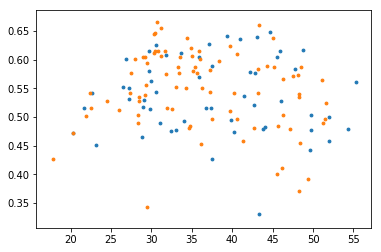

     HL1  HL2   trainr2    testr2       time
5      8    9  0.786962  0.330660  43.326119
121    9    6  0.749528  0.342640  29.427690
88     9    6  0.767855  0.371136  48.285256
82     9    6  0.785599  0.391201  49.337750
136    9    6  0.791003  0.400626  45.599272
132    9    6  0.827691  0.410620  46.214963
85     9    6  0.476839  0.426354  17.807268
0      8    9  0.826773  0.427654  37.505651
7      8    9  0.742035  0.441868  49.603523
59     8    9  0.510694  0.451195  23.106905
71     9    6  0.671921  0.453467  36.102214
100    9    6  0.749382  0.454671  48.399807
51     8    9  0.758047  0.458117  52.024575
18     9    6  0.677587  0.458305  41.308752
38     8    9  0.749627  0.465788  28.805135
34     8    9  0.523981  0.471762  20.229162
12     9    6  0.531311  0.472886  20.236992
33     8    9  0.748729  0.474105  40.188273
22     8    9  0.738319  0.476525  32.441257
6      8    9  0.751988  0.476678  33.018939
32     8    9  0.748886  0.477940  49.804179
138    9  

,HL2,trainr2,testr2,time
HL1,,,,
8,9,0.709719,0.538098,37.479220
9,6,0.715571,0.547210,36.442561


In [54]:
mydf = pd.DataFrame(mydflist, columns = ['HL1', 'HL2', 'trainr2', 'testr2', 'time'])
mydf.drop(mydf[mydf['testr2'] < 0].index, inplace = True)
plt.scatter(mydf[mydf['HL1'] == 8]['time'], mydf[mydf['HL1'] == 8]['testr2'], s = 8)
plt.scatter(mydf[mydf['HL1'] == 9]['time'], mydf[mydf['HL1'] == 9]['testr2'], s = 8)
plt.show()
print(mydf.sort_values('testr2'))
mydf.groupby('HL1').mean()